# Предсказание температуры стали

### Задача

---

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Чтобы не проводить эксперементы в реальных условиях, технологам нужна модель для предсказания температуры стали в зависимости от процесса обработки.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Цель проекта**

Построить модель для определения температуры стали в зависимости от различных параметров процесса обработки. Точность модели не должна превышать MAE = 6.8.

### Данные

---

В нашем распоряжении есть данные о температуре и итерациях обработки разных партий стали.

Данные, полученные из разных источников, лежат в разных файлах:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План проекта

---

1. Обзор и исследование данных.
    - Чтение данных. Изучение датасетов. Исследовательский анализ данных.
2. Обучение моделей.
    - Предобработка и создание новых признаков. Объединение признаков из разных талбиц. Обучение моделей: линейная регрессия, случайный лес, LightGBM, XGBoost, CatBoost. Тестирование лучшей модели.
3. Вывод.

---

## Обзор и исследование данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [2]:
RANDOM_STATE = 42

### Чтение данных

In [3]:
file_names = ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']
dfs = {}

path = '../datasets/final_steel/'

for name in file_names:
    df = pd.read_csv(path + name + '.csv')
    dfs[name] = df

### Изучение датасетов

Посмотрим на общую информацию о данных в датасетах.

In [4]:
def general_info(data):
    """Выводит общую информацию о датасете"""
    display(data.head())
    
    print('Размер =', data.shape, '\n')
    
    print(data.info())
    print('\nПропуски:\n', data.isna().sum(), sep='')
    print('\nЯвных дубликатов:', data.duplicated().sum())
    
    display(data.describe())
    
    if (data.drop('key', axis=1).dtypes != 'object').sum() != 0:
        fig, ax = plt.subplots()
        sns.heatmap(data.corr(numeric_only=True),  annot=True, fmt='.1f', ax=ax)
        plt.show()

====================== data_arc ======================



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Размер = (14876, 5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

Пропуски:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Явных дубликатов: 0


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


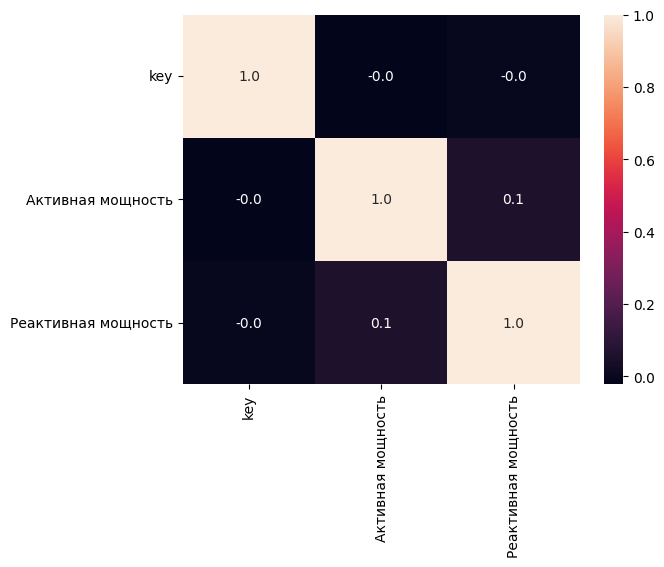


====================== data_bulk ======================



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Размер = (3129, 16) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

Пропуски:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


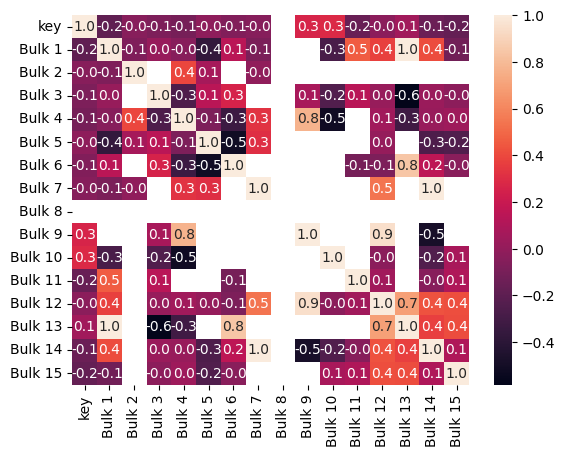


====================== data_bulk_time ======================



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Размер = (3129, 16) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

Пропуски:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8  

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



====================== data_gas ======================



,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Размер = (3239, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

Пропуски:
key      0
Газ 1    0
dtype: int64

Явных дубликатов: 0


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


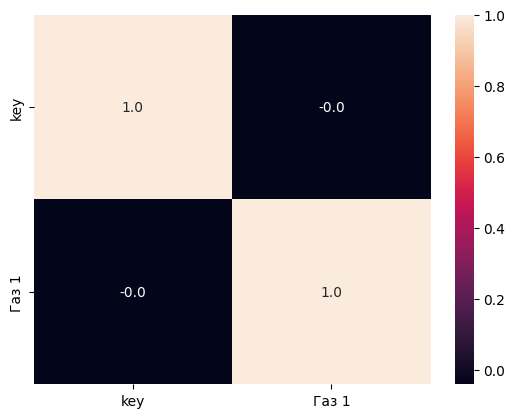


====================== data_temp ======================



,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Размер = (15907, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

Пропуски:
key                0
Время замера       0
Температура     2901
dtype: int64

Явных дубликатов: 0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


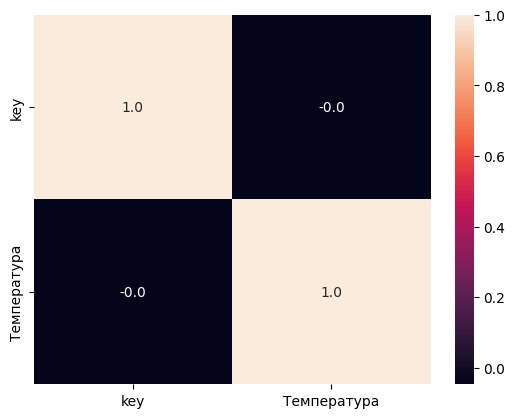


====================== data_wire ======================



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Размер = (3081, 10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

Пропуски:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Явных дубликатов: 0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


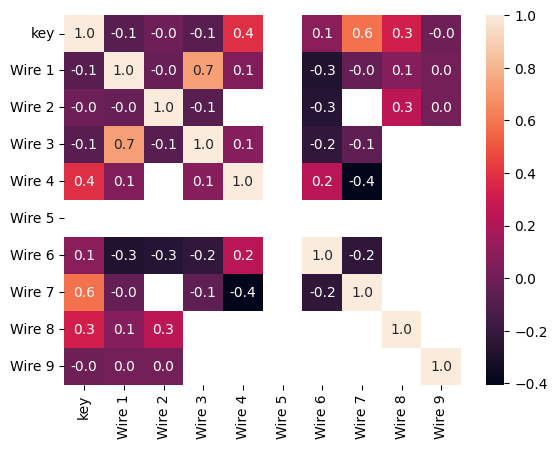


====================== data_wire_time ======================



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Размер = (3081, 10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

Пропуски:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Явных дубликатов: 0


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [5]:
for name in dfs:
    print(f"====================== {name} ======================")
    print()
    general_info(dfs[name])
    print()

**Промежуточный вывод:**

В нашем распоряжении 7 таблиц разного содержания и размера. Таблицы могут быть связаны по столбцу `key`, в котором прописан номер партии. Ни в одной таблице нет явных дубликатов. Целевая переменная (температура) лежит в таблице `data_temp`.

Что обнаружили:
- `key` принимает значения от 1 до 3241. По размерам таблиц можем сделать вывод, что данные могут быть указаны не для всех партий; 
- размеры парных таблиц (`data_bulk`/`data_bulk_time` и `data_wire`/`data_wire_time`) одинаковые;
- пропуски есть почти во всех таблицах. Пропусков нет только в `data_arc` и `data_gas`;
- есть аномальные значения, например, 'Реактивная мощность' = -715 в `data_arc`;
- в `data_bulk` и `data_wire` есть столбцы с единственным значением и столбцы с высокой корреляцией.


Что стоит сделать:
- определить номера партий, для которых есть все необходимые данные;
- проверить соответствие парных таблиц: объем и время добавления легирующих материалов должны быть в одинаковых  ячейках;
- обработать пропуски;
- обработать аномальные значения;
- привести даты к формату datetime;
- для удобства можно привести названия столбцов к змеиному регистру.

### Исследовательский анализ

Посмотрим внимательнее на каждую таблицу.

**1) data_arc**

Данные об электродах.

In [6]:
dfs['data_arc'].head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Судя по таблице (и исходя из тех. процесса), каждая партия проходит ряд этапов нагрева. Посмотрим на распределение количества этапов.

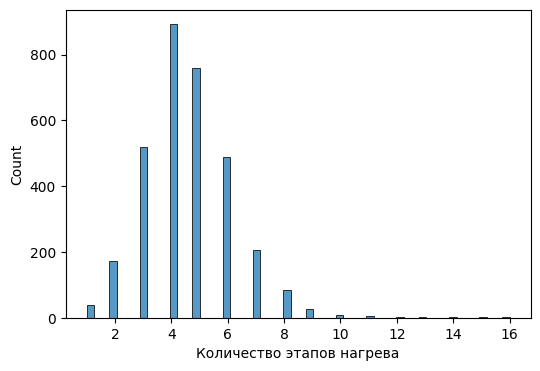

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(dfs['data_arc'].groupby('key')['Активная мощность'].count()).set(xlabel='Количество этапов нагрева')
plt.show()

In [8]:
dfs['data_arc'].groupby('key')['Активная мощность'].count().describe()

count    3214.000000
mean        4.628500
std         1.608647
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: Активная мощность, dtype: float64

Чаще всего проходит 4 этапа нагрева, но бывают случаи и с одним этапом нагрева, и еще реже с 10-16.

Посмотрим на диаграмму размаха для активной и реактивной мощностей.

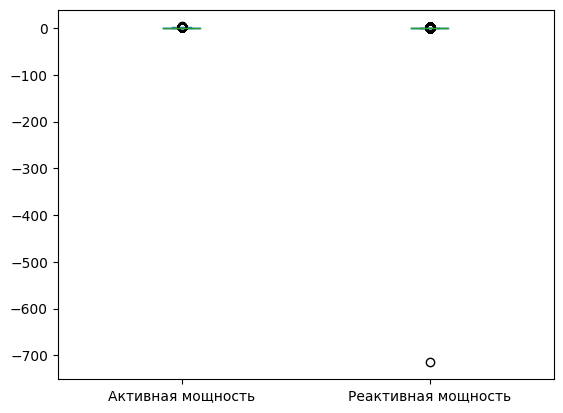

In [9]:
dfs['data_arc'][['Активная мощность', 'Реактивная мощность']].plot.box()
plt.show()

Есть аномальное значение реактивной мощности, равное примерно -715. Если не рассматривать это экстремальное значение, распределения активной и реактивной мощностей довольно похожи.

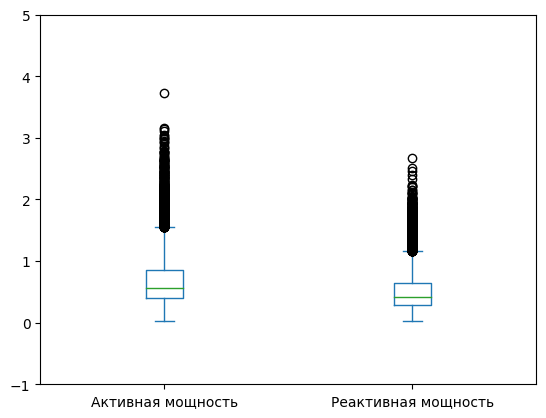

In [10]:
dfs['data_arc'][['Активная мощность', 'Реактивная мощность']].plot.box(ylim=(-1,5))
plt.show()

Посмотрим, коррелируют ли они между собой.

In [11]:
dfs['data_arc'][dfs['data_arc']['Реактивная мощность'] > 0][['Активная мощность', 'Реактивная мощность']].corr()

,Активная мощность,Реактивная мощность
Активная мощность,1.000000,0.963182
Реактивная мощность,0.963182,1.000000


Мощности сильно коррелируют между собой. Исходя из этого, можно заменить экстремальное значение реактивной мощности на значение, пропорциональное активной мощности. Коэффициент пропорциональности взять как медианное значение от отношений реактивной к активной мощности. Также из активной и реактивной мощности можно сформировать один признак.

*Признаки*. Из таблицы `data_arc` предлагается сформировать следующие признаки:

- `total_heat` - характеризует общее количество тепла/энергии, потраченное на нагревание. Рассчитывается по формуле:

$$
\text{total_heat}= \sum_k\Delta t_k P_{k, total},
$$
где $k$ - этап нагрева, $\Delta t_k$ - время $k$-го этапа нагрева, $P_{k, total}$ - полная мощность на $k$-ом этапе:

$$
\Delta t_k = \text{Конец нагрева дугой}_k - \text{Начало нагрева дугой}_k \\
P_{k, total} = \sqrt{\text{Активная мощность}_k^2 + \text{Реактивная мощность}_k^2}
$$

- `total_cool` - время без нагрева. Рассчитывается как сумма разностей между началом $k$-го нагрева и концом $(k-1)$-го нагрева:

$$
\text{total_cool} = \sum_k (\text{Начало нагрева дугой}_k - \text{Конец нагрева дугой}_{k-1})
$$

Соответственно, если будет два этапа нагрева, то `total_cool` - это время между этими этапами, а если всего один нагрев, то `total_cool` будет равно 0.

- `n_heat` - количество этапов нагрева.

**2) data_bulk**

Данные о подаче сыпучих материалов (объём).

In [12]:
dfs['data_bulk'].head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


В таблице много пропусков, которые, логично, соответствуют нулевому объему используемого материала. Поэтому пропуски будем заменять на 0.

In [13]:
dfs['data_bulk'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Среди сыпучих материалов есть те, которые добавлялись в малое количество партий. Так как данных по ним мало, объединим их в один признак. Сложим объем материалов, которые добавлялись меньше 100 раз: `Bulk 2`, `5`, `7-9`, `13`.

Чаще всего используются материалы `Bulk 12`, `14`, `15`.

Посмотрим на распределения объема материала в зависимости от его типа.

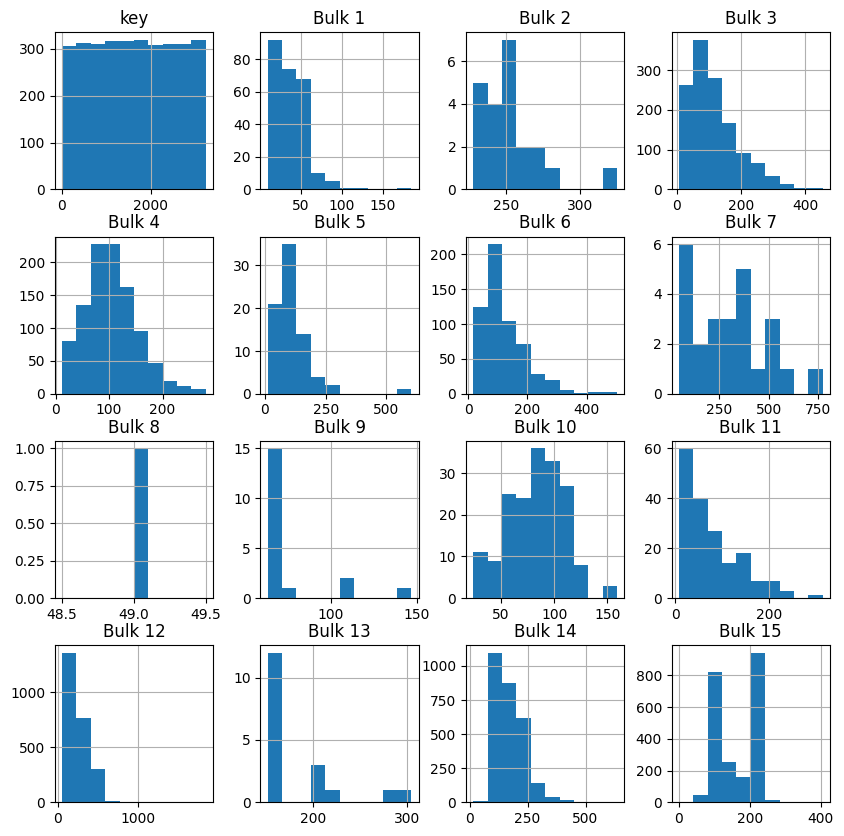

In [14]:
dfs['data_bulk'].hist(figsize=(10, 10))
plt.show()

Если исключить оговоренные ранее материалы, то по распределениям оставшихся можно сказать, что в основном в сталь добавляется около 200 единиц сыпучего материала одного типа. В распределении `Bulk 12` есть сильно выбивающееся значение, но на производстве говорят, что это редкое, но корректное значение, поэтому удалять его не будем.

In [15]:
dfs['data_bulk']['Bulk 12'].sort_values(ascending=False).head()

303     1849.0
1933     853.0
1755     833.0
308      775.0
1410     774.0
Name: Bulk 12, dtype: float64

Распределение без выброса:

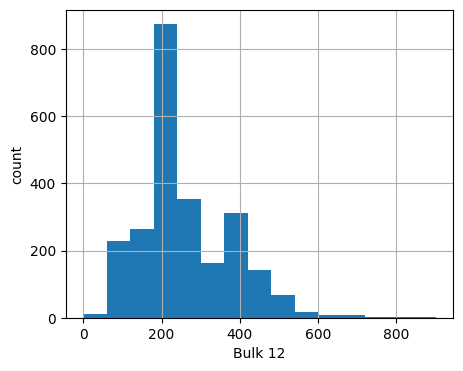

In [16]:
dfs['data_bulk']['Bulk 12'].hist(range=(0, 900), figsize=(5,4), bins=15).set(xlabel='Bulk 12', ylabel='count')
plt.show()

Распределения в основном похожи между собой, кроме распределения `Bulk 15` с выраженной бимодальностью.

Посмотрим, сколько суммарно сыпучего материала добавляют к каждой партии.

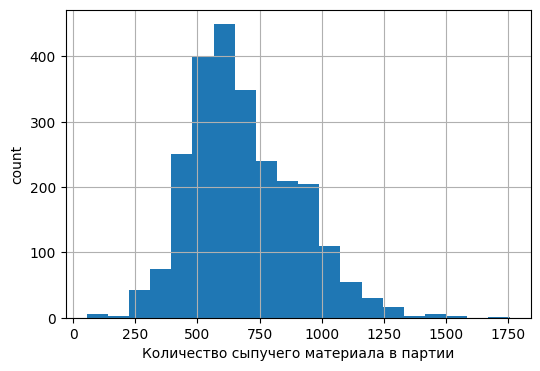

In [17]:
dfs['data_bulk'][dfs['data_bulk']['Bulk 12'] < 1000].loc[:, 'Bulk 1':'Bulk 15']\
    .agg("sum", axis="columns")\
    .hist(figsize=(6, 4), bins=20)\
    .set(xlabel='Количество сыпучего материала в партии', ylabel='count')
plt.show()

In [18]:
dfs['data_bulk'][dfs['data_bulk']['Bulk 12'] < 1000].loc[:, 'Bulk 1':'Bulk 15'].agg("sum", axis="columns").describe()

count    2449.000000
mean      685.873826
std       214.953309
min        54.000000
25%       529.000000
50%       650.000000
75%       827.000000
max      1757.000000
dtype: float64

В каждую партию в основном добавляется от 500 до 900 единиц сыпучего материала. Если объединить эту информацию с предыдущим выводом, то можно сказать, что в основном для каждой партии используется 2-5 различных сыпучих материала.

*Признаки.* Из таблицы `data_bulk` предлагается сформировать следующие признаки:

- `bulk_i` - объем сыпучего i-го материала. Значения i: 1, 3, 4, 6, 10, 11, 12, 14, 15;
- `extra_bulk` - суммарный объем оставшихся сыпучих материалов;
- `n_bulk` - число добавленных различных сыпучих материалов.

**3) data_bulk_time**

Данные о подаче сыпучих материалов (время).

In [19]:
dfs['data_bulk_time'].head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Здесь пропуски также соответствуют отсутствию подачи материала. В некоторых ячейках время совпадает, возможно, материалы засыпались одновременно.

Признаки из этой таблицы генерировать не будем, только проверим соответствие с таблицей `data_bulk`. В таблицах `data_bulk` и `data_bulk_time` должны быть заполнены одинаковые ячейки:

In [20]:
print('Несоответствий в ячейках data_bulk и data_bulk_time:',
      (dfs['data_bulk'].isna() != dfs['data_bulk_time'].isna()).sum().sum())

Несоответствий в ячейках data_bulk и data_bulk_time: 0


Заодно проверим, что номера партий совпадают.

In [21]:
print('Несовпадающих номеров партий в data_bulk и data_bulk_time:',
      (dfs['data_bulk']['key'] != dfs['data_bulk_time']['key']).sum())

Несовпадающих номеров партий в data_bulk и data_bulk_time: 0


Также проверим, что среди `key` нет дубликатов. 

In [22]:
dfs['data_bulk_time']['key'].duplicated().sum()

0

**4) data_wire**

Данные о проволочных материалах (объём). Анализ аналогичен `data_bulk`.

In [23]:
dfs['data_wire'].head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пропуски заменим на 0.

In [24]:
dfs['data_wire'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Оставим данные по `Wire 1` и `Wire 2`, так как остальных компонент слишком мало.

Посмотрим на распределения объема материала в зависимости от его типа.

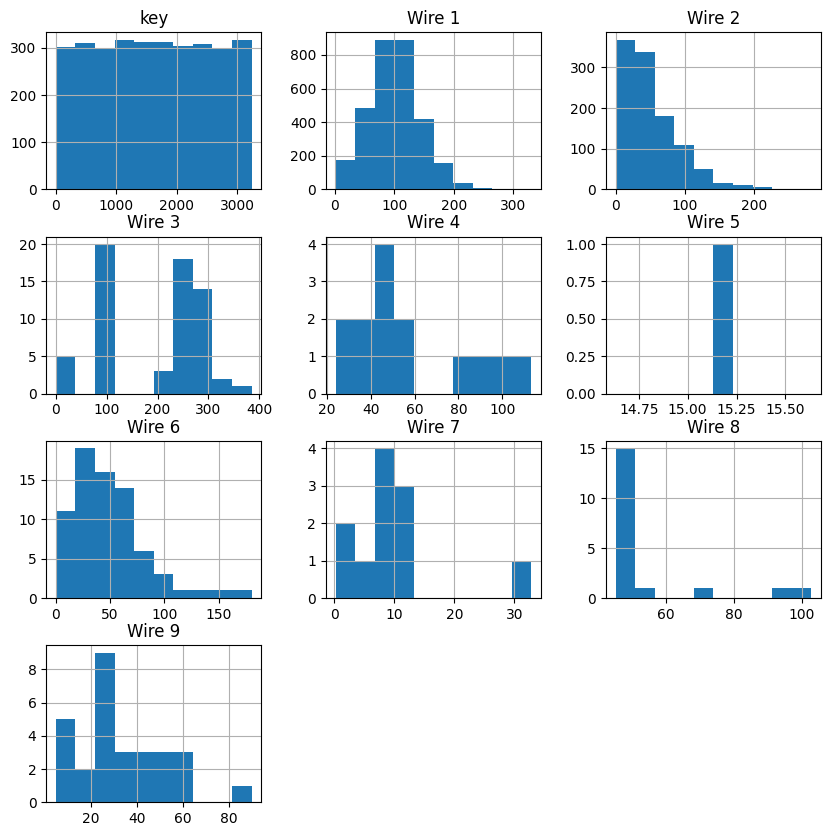

In [25]:
dfs['data_wire'].hist(figsize=(10, 10))
plt.show()

В основном в сталь добавляется около 100 единиц проволочного материала одного типа.

Посмотрим, сколько суммарно проволочного материала добавляют к каждой партии.

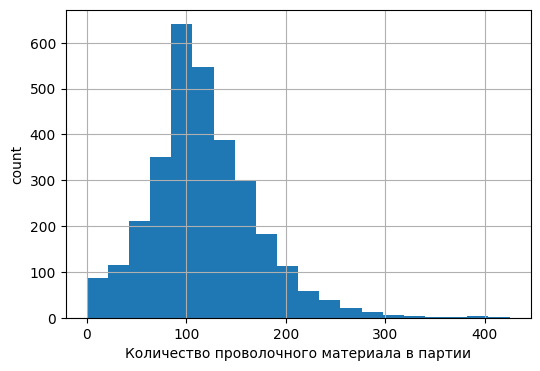

In [26]:
dfs['data_wire'].loc[:, 'Wire 1':'Wire 2']\
    .agg("sum", axis="columns")\
    .hist(figsize=(6, 4), bins=20)\
    .set(xlabel='Количество проволочного материала в партии', ylabel='count')
plt.show()

In [27]:
dfs['data_wire'].loc[:, 'Wire 1':'Wire 2'].agg("sum", axis="columns").describe()

count    3081.000000
mean      117.757145
std        53.117368
min         0.000000
25%        85.088638
50%       112.132797
75%       147.223437
max       425.145752
dtype: float64

В каждую партию в среднем добавляется около 100 единиц проволочного материала.

*Признаки.* Из таблицы `data_wire` предлагается сформировать следующие признаки:

- `wire_1` - объем 1-го проволочного материала;
- `wire_2` - объем 2-го проволочного материала;
- `extra_wire` - суммарный объем оставшихся проволочных материалов;
- `n_wire` - число добавленных различных проволочных материала.

**5) data_wire_time**

Данные о проволочных материалах (время).

In [28]:
dfs['data_wire_time'].head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пропуски соответствуют отсутствию подачи материала.

Признаки из этой таблицы также генерировать не будем, проверим соответствие с таблицей `data_wire`:

In [29]:
print('Несоответствий в ячейках data_wire и data_wire_time:',
      (dfs['data_wire'].isna() != dfs['data_wire_time'].isna()).sum().sum())

Несоответствий в ячейках data_wire и data_wire_time: 0


Проверим, что номера партий совпадают.

In [30]:
print('Несовпадающих номеров партий в data_wire и data_wire_time:',
      (dfs['data_wire']['key'] != dfs['data_wire_time']['key']).sum())

Несовпадающих номеров партий в data_wire и data_wire_time: 0


Проверим наличие дубликатов `key`.

In [31]:
dfs['data_wire_time']['key'].duplicated().sum()

0

**6) data_gas**

Данные о продувке сплава газом

In [32]:
dfs['data_gas'].head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [33]:
dfs['data_gas'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Здесь пропусков нет, однако, для двух партий количество газа не указано (всего значений `key` - 3241). Посмотрим на диаграмму размаха.

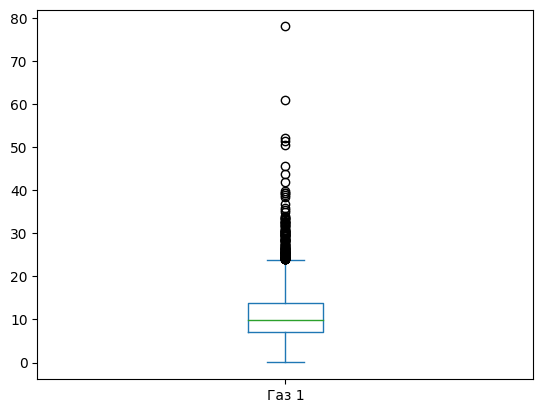

In [34]:
dfs['data_gas']['Газ 1'].plot.box()
plt.show()

"Выбросы" убирать не будем, так как они не очень похожи на аномальные значения.

In [35]:
dfs['data_gas']['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

В основном для продувки используется около 10 единиц газа. Можно предположить, что количество газа пропорционально количеству итераций легирования разными материалами.

Проверим наличие дубликатов `key`.

In [36]:
dfs['data_gas']['key'].duplicated().sum()

0

*Признаки*. Из таблицы `data_gas` предлагается сформировать следующие признаки:
- `gas` - количество газа.

**7) data_temp**

Результаты измерения температуры.

In [37]:
dfs['data_temp'].head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [38]:
dfs['data_temp'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


В данных есть пропуски, и температура для каждой партии может измеряться несколько раз. Посмотрим на распределение количества замеров температуры с учетом пропусков.

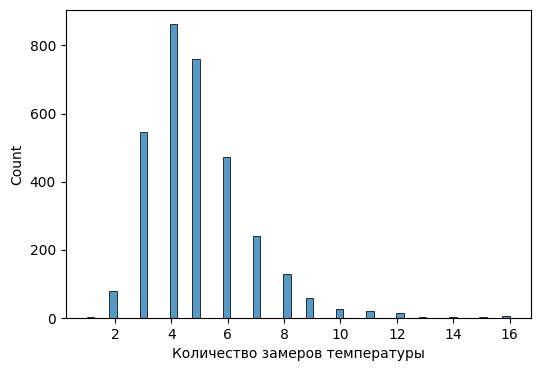

In [39]:
plt.figure(figsize=(6, 4))
sns.histplot(dfs['data_temp'].groupby('key')['Время замера'].count()).set(xlabel='Количество замеров температуры')
plt.show()

In [40]:
dfs['data_temp'].groupby('key')['Время замера'].count().describe()

count    3216.000000
mean        4.946206
std         1.793169
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        16.000000
Name: Время замера, dtype: float64

Распределение количества замеров похоже на распределение количества этапов нагрева. Можно предположить, что в целом тех. процесс соблюдался, и температура, кроме начального значения, измерялась каждый раз после этапа нагрева, в течение которого добавлялись легирующие материалы. 

Однако, в таблице много пропущенных значений температуры. Нам нужны только те партии, где есть замер начальной и конечной температуры. Но сначала проверим, расположены ли замеры хронологическом порядке.

In [41]:
pd.to_datetime(dfs['data_temp']['Время замера'], format="%Y-%m-%d %H:%M:%S").is_monotonic_increasing

False

В общем по таблице порядок не соблюдается, но внутри каждой группы замеров порядок есть:

In [42]:
group_times_bool = dfs['data_temp'].groupby('key').apply(lambda x: pd.to_datetime(x['Время замера'], format="%Y-%m-%d %H:%M:%S").is_monotonic_increasing)
print(group_times_bool)
print('Порядок внутри групп соблюдается:', group_times_bool.sum() == len(group_times_bool))

key
1       True
2       True
3       True
4       True
5       True
        ... 
3237    True
3238    True
3239    True
3240    True
3241    True
Length: 3216, dtype: bool
Порядок внутри групп соблюдается: True


Пример несостыковок по времени в общей таблице:

In [43]:
dfs['data_temp'].query("key in [24, 25]")

,key,Время замера,Температура
129,24,2019-05-04 06:03:13,1578.0
130,24,2019-05-04 06:12:44,1584.0
131,24,2019-05-04 06:16:14,1594.0
132,24,2019-05-04 06:45:11,1566.0
133,24,2019-05-04 06:54:44,1572.0
134,24,2019-05-04 06:59:55,1585.0
135,25,2019-05-04 06:25:39,1594.0
136,25,2019-05-04 06:26:03,1579.0
137,25,2019-05-04 06:26:50,1576.0
138,25,2019-05-04 06:36:47,1575.0


Здесь видим, что периоды замеров температуры 24 и 25 партии перекрываются. Это можно объяснить наличием нескольких плавильных ковшей.

Сейчас можем проверить, у всех ли партий есть замер первой и последней температуры и замеров как минимум два.

In [44]:
temp_info = dfs['data_temp'].groupby('key').agg(first=('Температура', lambda x: x.iloc[0]),
                                                last=('Температура', lambda x: x.iloc[-1]),
                                                count=('Время замера', "count"))
temp_info.head()

,first,last,count
key,,,
1,1571.0,1613.0,5
2,1581.0,1602.0,6
3,1596.0,1599.0,5
4,1601.0,1625.0,3
5,1576.0,1602.0,2


In [45]:
print('Партии, у которых нет замера начальной и/или конечной температуры либо замер всего один:',
      ((temp_info['first'].isna()) | (temp_info['last'].isna()) | (temp_info['count'] == 1)).sum())

Партии, у которых нет замера начальной и/или конечной температуры либо замер всего один: 741


Эти партии нужно будет исключить из рассмотрения.

Построим диаграммы размаха первых измерений температуры и последних.

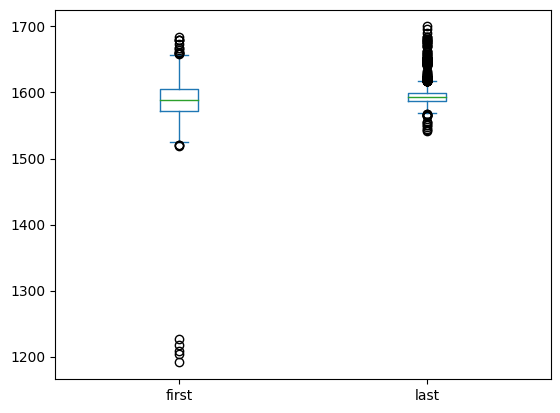

In [46]:
temp_info[['first', 'last']].plot.box()
plt.show()

In [47]:
temp_info[['first', 'last']].describe()

,first,last
count,3216.000000,2477.000000
mean,1588.592040,1595.334275
std,29.137454,16.019339
min,1191.000000,1541.000000
25%,1572.000000,1587.000000
50%,1588.000000,1593.000000
75%,1606.000000,1599.000000
max,1684.000000,1700.000000


У начальной температуры есть несколько выбросов - это значения меньше температуры плавления. Температура плавления стали лежит в диапазоне 1350-1535 °C ([источник](http://thermalinfo.ru/svojstva-materialov/metally-i-splavy/temperatura-plavleniya-i-kipeniya-metallov-plotnost-i-teploprovodnost)), поэтому партии с начальной температурой меньше 1350 °C также рассматривать не будем.

Посмотрим на распределения начальной и конечной температур.

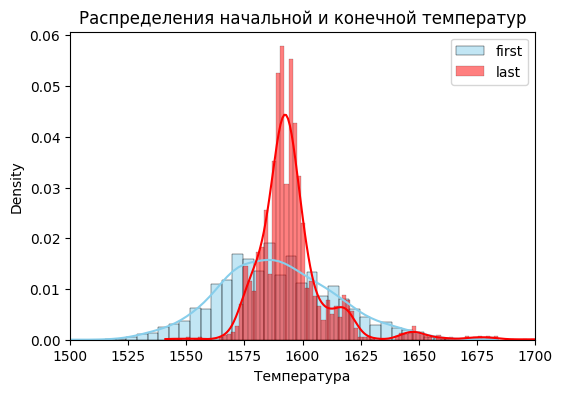

In [48]:
plt.figure(figsize=(6, 4))
sns.histplot(temp_info['first'], stat= 'density', color="skyblue", label="first", kde=True)
sns.histplot(temp_info['last'], stat= 'density', color="red", label="last", kde=True)\
            .set(xlabel='Температура', xlim=(1500, 1700), title='Распределения начальной и конечной температур')
plt.legend()
plt.show()

Моды распределений температур лежат довольно близко, около 1590 °C, но мода начальной температуры все равно меньше. В правом "крыле" конечных температур как будто не хватает значений, так как плотность начальных температур здесь выше. Возможно, это связано с отсутствием измерений по большей части именно конечной температуры:

In [49]:
print('Партии, у которых нет замера конечной температуры:', temp_info['last'].isna().sum())

Партии, у которых нет замера конечной температуры: 739


Посмотрим на распределение температур для партий, у которых есть замер и начальной и конечной температур.

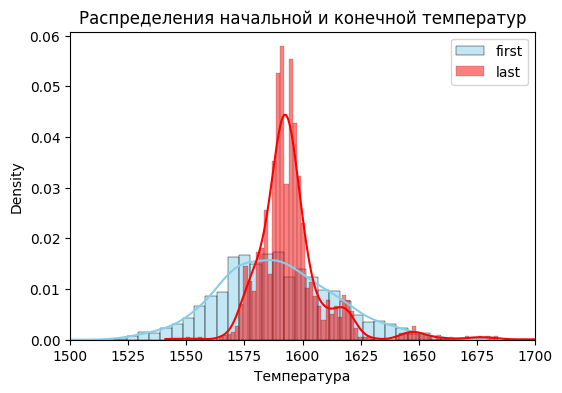

In [50]:
mask = (~temp_info['first'].isna()) & (~temp_info['last'].isna()) & (temp_info['count'] != 1)

plt.figure(figsize=(6, 4))
sns.histplot(temp_info[mask]['first'], stat= 'density', color="skyblue", label="first", kde=True)
sns.histplot(temp_info[mask]['last'], stat= 'density', color="red", label="last", kde=True)\
            .set(xlabel='Температура', xlim=(1500, 1700), title='Распределения начальной и конечной температур')
plt.legend()
plt.show()

Распределение почти не изменилось. Значит, конечная температура не всегда больше начальной:

In [51]:
((temp_info[mask]['last'] - temp_info[mask]['first']) > 0).sum()

1521

Конечная температура больше начальной у 1521 из 2475 партий. Значит, не всегда целью является увеличение температуры. Главное - подвести температуру к определенному значению. Поэтому распределение конечных температур более узкое у своих пиков.

*Признаки*. Из таблицы `data_temp` предлагается сформировать следующие признаки:
- `temp_init` - начальная температура стали;
- `temp_filan` - конечная температура стали, **целевой признак**;
- `n_temp` - количество измерений температуры.

**8)** Попробуем изобразить на временной шкале изменение температуры и **этапы обработки** первой партии стали. 

In [52]:
key = 1

data_temp_1 = dfs['data_temp'].query('key == @key')
data_arc_1 = dfs['data_arc'].query('key == @key')
data_bulk_time_1 = dfs['data_bulk_time'].query('key == @key')
data_wire_time_1 = dfs['data_wire_time'].query('key == @key')

In [53]:
%%capture
data_temp_1['Время замера'] = pd.to_datetime(data_temp_1['Время замера'], format='%Y-%m-%d %H:%M:%S')
data_arc_1['Начало нагрева дугой'] = pd.to_datetime(data_arc_1['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc_1['Конец нагрева дугой'] = pd.to_datetime(data_arc_1['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time_1['Bulk 4'] = pd.to_datetime(data_bulk_time_1['Bulk 4'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time_1['Bulk 12'] = pd.to_datetime(data_bulk_time_1['Bulk 12'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time_1['Bulk 14'] = pd.to_datetime(data_bulk_time_1['Bulk 14'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time_1['Bulk 15'] = pd.to_datetime(data_bulk_time_1['Bulk 15'], format='%Y-%m-%d %H:%M:%S')
data_wire_time_1['Wire 1'] = pd.to_datetime(data_wire_time_1['Wire 1'], format='%Y-%m-%d %H:%M:%S')

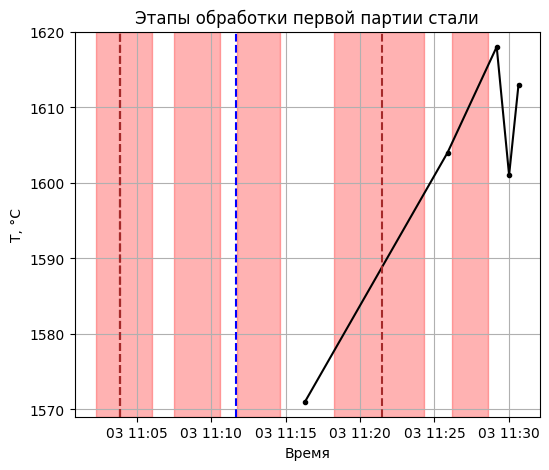

In [54]:
fig, ax = plt.subplots(figsize=(6, 5))
ymin = data_temp_1['Температура'].min() - 2
ymax = data_temp_1['Температура'].max() + 2
ax.set_ylim(ymin, ymax)
ax.set_ylabel("Т, °C")
ax.set_xlabel('Время')
ax.set_title('Этапы обработки первой партии стали')
ax.grid()


ax.plot(data_temp_1['Время замера'], data_temp_1['Температура'], '.-', c='black')
ax.fill((data_arc_1['Начало нагрева дугой'], data_arc_1['Конец нагрева дугой'], data_arc_1['Конец нагрева дугой'], data_arc_1['Начало нагрева дугой']),
        (ymax, ymax, ymin, ymin), color='red', alpha=0.3 )
plt.vlines(data_bulk_time_1[['Bulk 4', 'Bulk 12', 'Bulk 14', 'Bulk 15']], ymin=ymin, ymax=ymax, linestyles='dashed', colors='brown')
plt.vlines(data_wire_time_1['Wire 1'], ymin=ymin, ymax=ymax, linestyles='dashed', colors='blue')

plt.show()

На графике черные точки соответствуют измерениям температуры стали, красные области - этапы нагрева, пунктирные коричневые линии - моменты подачи сыпучих материалов, синяя пунктирная линия - момент подачи проволочного материала.

Видим, что количество замеров температуры, число этапов нагрева и добавления легирующих материалов одинаковое и равно 5 (момент добавления 3 из 4 сыпучих материалов совпадает). Однако, моменты времени разных этапов обработки несинхронизированы.

**Промежуточный вывод**

Ииследовательский анализ помог обнаужить еще ряд проблем сырых датасетов, которые нужно будет учесть на этапе обработки и которые будут описаны далее в подробном плане работ. Также в ходе анализа были получены следующие наблюдения:

*data_arc*:
- в процессе обработки сталь проходит несколько этапов нагрева. В основном это 4 этапа, но бывают случаи и с одним этапом нагрева, и еще реже с 10-16;
- активная и реактивная мощности электродов сильно коррелируют (коэффициент корреляции 0.96), поэтому можно использовать либо одну из них, либо общую мощность как корень из суммы квадратов;

*data_bulk, data_bulk_time, data_wire, data_wire_time*:
- парные таблицы (`data_bulk`/`data_bulk_time` и `data_wire`/`data_wire_time`) соответствуют друг другу: объем и время добавления легирующих материалов находятся в одинаковых ячейках. Также номера партий совпадают и в них нет дубликатов;
- среди сыпучих и проволочных материалов есть те, которые добавлялись в малое количество партий. Будем учитывать только их суммарный объем. Индивидуально учитывать будем следующие: `Bulk 1, 3, 4, 6, 10, 11, 12, 14, 15` и `Wire 1, 2`. Также среди сыпучих чаще всего используются материалы `Bulk 12, 14, 15`;
- в распределении объема материала `Bulk 15` наблюдается две моды: около 100 и 200 единиц;
- в основном в сталь добавляется около 200 единиц сыпучего материала одного типа и около 100 единиц проволочного материала одного типа;
- в каждую партию в среднем добавляется от 500 до 900 единиц сыпучего материала и около 100 единиц проволочного материала. Значит для каждой партии в среднем используется 2-5 различных сыпучих материала и 1 проволочный;

*data_gas*:
- в основном для продувки используется около 10 единиц газа. Есть предположение, что количество газа пропорционально количеству итераций легирования разными материалами. Это можно будет проверить позже, когда получим все признаки;

*data_temp*:
- распределение количества замеров температуры похоже на распределение количества этапов нагрева. Можно предположить, что в целом тех. процесс соблюдался, и температура, кроме начального значения, измерялась каждый раз после этапа нагрева, в течение которого добавлялись легирующие материалы;
- периоды замеров температуры некоторых партии перекрываются. Это можно объяснить наличием нескольких плавильных ковшей;
- у части партий нет замеров конечной температуры (739), либо замер только один (2);
- моды распределений начальной и конечной температур лежат довольно близко, около 1590 °C, но мода начальной температуры все равно меньше;
- конечная температура не всегда больше начальной. Это условие соблюдается только для 1521 из 2475 партий. Значит, главная цель - подвести температуру к определенному значению. Поэтому распределение конечных температур более узкое у своих пиков.

*этапы обработки*:
- для пробной партии (`key` = 1) количество замеров температуры, число этапов нагрева и добавления легирующих материалов одинаковое. Однако, моменты времени разных этапов обработки несинхронизированы;
- не для всех партий есть все этапы обработки.


## Подготовка признаков

Подготовим таблицы с признаками для последующего объединения.

### data_arc

**1)** Приведем время к типу datetime

In [55]:
data_arc = dfs['data_arc'].copy()
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format="%Y-%m-%d %H:%M:%S")
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format="%Y-%m-%d %H:%M:%S")

# data_arc.dtypes

**2)** Заменим аномальное значение реактивной мощности. Найдем медиану отношений реактивной и активной мощности $k$ и умножим ее на известное значение активной мощности.

In [56]:
k = (data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'] / \
     data_arc[data_arc['Реактивная мощность'] > 0]['Активная мощность']).median()

data_arc.loc[np.where(data_arc['Реактивная мощность'] < 0)[0], 'Реактивная мощность'] = \
    k * data_arc[data_arc['Реактивная мощность'] < 0]['Активная мощность']

In [57]:
len(data_arc[data_arc['Реактивная мощность'] < 0])

0

**3)** Найдем полную мощность как корень из суммы квадратов активной и реактивной мощностей.

In [58]:
data_arc['total_power'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)

**4)** Рассчитаем время нагрева в секундах как разность времени конца и начала нагрева и умножим это время на полную мощность.

In [59]:
data_arc['heat_time'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds
data_arc['heat'] = data_arc['total_power'] * data_arc['heat_time']

**5)** Посчитаем время без нагрева `cool_time` как разность времен между началом нагрева и концом предыдущего нагрева. При этом первые значения `cool_time` в каждой партии будут нерепрезентативными, их не нужно будет учитывать в общей сумме.

In [60]:
data_arc['cool_time'] = (data_arc['Начало нагрева дугой'] - data_arc['Конец нагрева дугой'].shift()).dt.seconds
data_arc.head(7)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,total_power,heat_time,heat,cool_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228,272.149755,NaN
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185,177.416785,86.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172,154.118502,71.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365,719.221394,218.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148,119.471318,110.0
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0.521549,137,71.452170,337.0
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1.574162,338,532.066853,139.0


**6)** Сгруппируем по партиям и найдем суммарный нагрев `total_heat`, суммарное время без нагрева `total_cool` и количество этапов нагрева `n_heat`. В каждой группе первые значения `total_cool` в сумме не учитываются.

In [61]:
arc_group = data_arc.groupby('key')\
            .agg(total_heat=('heat_time', 'sum'), total_cool=('cool_time', lambda x: x[1:].sum()), n_heat=('Активная мощность', 'count'))\
            .reset_index()
arc_group.head()

,key,total_heat,total_cool,n_heat
0,1,1098,485.0,5
1,2,811,333.0,4
2,3,655,870.0,5
3,4,741,352.0,4
4,5,869,493.0,4


### data_bulk

**1)** Для удобства переименуем столбцы.

In [62]:
data_bulk = dfs['data_bulk'].copy()
data_bulk.columns = [col.lower().replace(' ', '_') for col in data_bulk.columns]

**2)** Найдем количество и объем добавленных материалов и проверим, что нет партий, в которые ничего не добавили.

In [63]:
data_bulk['n_bulk'] = data_bulk.loc[:, 'bulk_1':'bulk_15'].apply('count', axis=1)
data_bulk['extra_bulk'] = data_bulk.loc[:, ['bulk_2', 'bulk_5', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13']].apply('sum', axis=1)

**3)** Удалим столбцы `bulk_2`, `5`, `7-9`, `13` и заполним пропуски 0.

In [64]:
data_bulk.drop(['bulk_2', 'bulk_5', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13'], axis=1, inplace=True)
data_bulk.fillna(0, inplace=True)

In [65]:
data_bulk.head()

,key,bulk_1,bulk_3,bulk_4,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,n_bulk,extra_bulk
0,1,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,4,0.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,4,0.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,4,0.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,4,0.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,4,0.0


### data_wire

**1)** Переименуем столбцы

In [66]:
data_wire = dfs['data_wire'].copy()
data_wire.columns = [col.lower().replace(' ', '_') for col in data_wire.columns]

**2)** Найдем количество и объем добавленных материалов.

In [67]:
data_wire['n_wire'] = data_wire.loc[:, 'wire_1':'wire_9'].apply('count', axis=1)
data_wire['extra_wire'] = data_wire.loc[:, 'wire_3':'wire_9'].apply('sum', axis=1)

**3)** Удалим столбцы `wire_3-9` и заполним пропуски 0.

In [68]:
%%capture
data_wire = data_wire[['key', 'wire_1', 'wire_2', 'n_wire', 'extra_wire']]
data_wire.fillna(0, inplace=True)

In [69]:
data_wire.head()

,key,wire_1,wire_2,n_wire,extra_wire
0,1,60.059998,0.00000,1,0.0
1,2,96.052315,0.00000,1,0.0
2,3,91.160157,0.00000,1,0.0
3,4,89.063515,0.00000,1,0.0
4,5,89.238236,9.11456,2,0.0


### data_gas

Переименуем столбец.

In [70]:
data_gas = dfs['data_gas'].copy()
data_gas = data_gas.rename(columns={'Газ 1': 'gas_1'})

data_gas.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### data_temp

**1)** Из таблицы `temp_info` возьмем партии, у которых есть замеры начальной и конечной температур.

In [71]:
data_temp = temp_info[mask].reset_index()
data_temp = data_temp.rename(columns={
    'first': 'temp_init',
    'last': 'temp_final',
    'count': 'n_temp'
})
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2475 non-null   int64  
 1   temp_init   2475 non-null   float64
 2   temp_final  2475 non-null   float64
 3   n_temp      2475 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 77.5 KB


Удалим партии, у которых начальная температура ниже 1350 °C.

In [72]:
data_temp = data_temp.query('temp_init >= 1350 and temp_final >= 1350')
data_temp.describe()

,key,temp_init,temp_final,n_temp
count,2471.000000,2471.000000,2471.000000,2471.000000
mean,1250.484015,1589.012950,1595.339943,4.950627
std,720.109488,25.004369,16.035215,1.794952
min,1.000000,1519.000000,1541.000000,2.000000
25%,628.500000,1572.000000,1587.000000,4.000000
50%,1252.000000,1588.000000,1593.000000,5.000000
75%,1872.500000,1605.000000,1599.000000,6.000000
max,2499.000000,1679.000000,1700.000000,16.000000


### Объединение таблиц

Объединим полученные таблицы по ключу `key`.

In [73]:
data = arc_group.merge(data_bulk, on='key', how='inner')\
                .merge(data_wire, on='key', how='inner')\
                .merge(data_gas, on='key', how='inner')\
                .merge(data_temp, on='key', how='inner')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2325 non-null   int64  
 1   total_heat  2325 non-null   int32  
 2   total_cool  2325 non-null   float64
 3   n_heat      2325 non-null   int64  
 4   bulk_1      2325 non-null   float64
 5   bulk_3      2325 non-null   float64
 6   bulk_4      2325 non-null   float64
 7   bulk_6      2325 non-null   float64
 8   bulk_10     2325 non-null   float64
 9   bulk_11     2325 non-null   float64
 10  bulk_12     2325 non-null   float64
 11  bulk_14     2325 non-null   float64
 12  bulk_15     2325 non-null   float64
 13  n_bulk      2325 non-null   int64  
 14  extra_bulk  2325 non-null   float64
 15  wire_1      2325 non-null   float64
 16  wire_2      2325 non-null   float64
 17  n_wire      2325 non-null   int64  
 18  extra_wire  2325 non-null   float64
 19  gas_1       2325 non-null  

Посмотрим на корреляцию признаков.

In [74]:
print(data['n_heat'].corr(data['n_bulk']+data['n_wire']))
print(data['n_temp'].corr(data['n_bulk']+data['n_wire']))

0.3150466429577006
0.07883789045031257


Число замеров температуры, число этапов нагрева и число добавленных материалов плохо коррелируют.

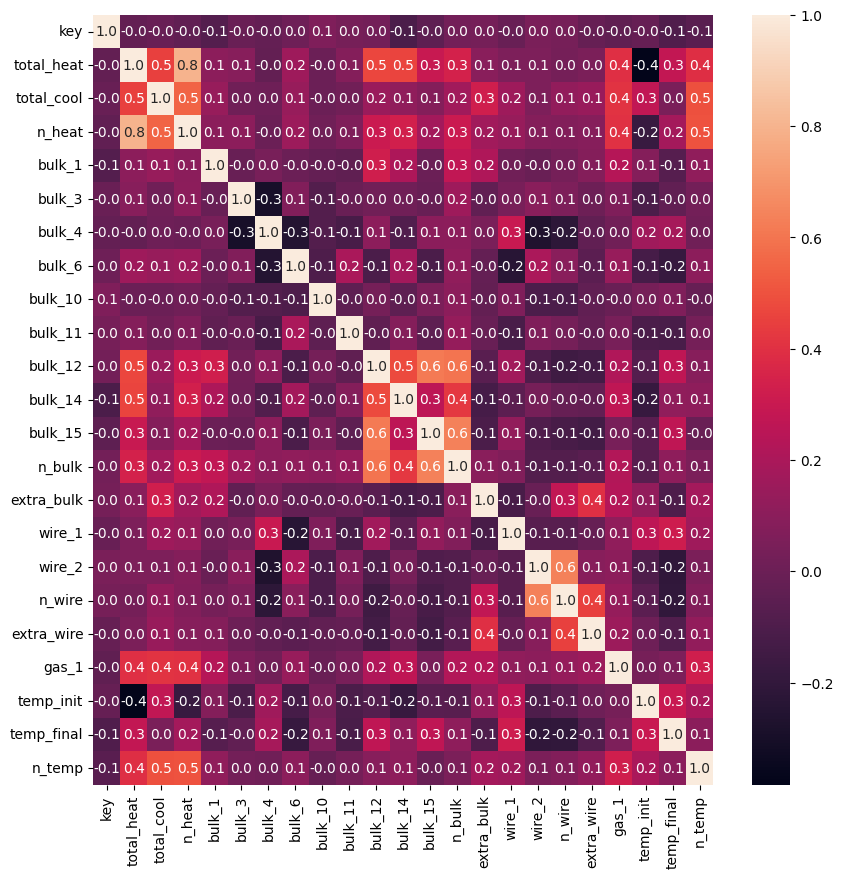

In [75]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, fmt='.1f', ax=ax)
plt.show()

Из-за высокой корреляции удалим признак `n_heat`.

In [76]:
data.drop('n_heat', axis=1, inplace=True)

### Подготовка признаков к обучению моделей

Выделим фичи и таргет и разделим выборку на кросс-валидационную и тестовую.

In [77]:
X = data.drop(['key', 'temp_final'], axis=1)
y = data['temp_final']

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [78]:
print('Размеры выборок:')
print(f'cv - {len(X_cv)} - {len(X_cv)/len(X):.1%}')
print(f'test - {len(X_test)} - {len(X_test)/len(X):.1%}')

Размеры выборок:
cv - 1743 - 75.0%
test - 582 - 25.0%


## Обучение моделей

Обучим 5 моделей: линейную регрессию, случайный лес, LGBMRegressor, XGBRegressor и CatBoostRegressor. Поиск гиперпараметров осуществляется через GridSearchCV.

In [79]:
def fit_model(estimator, param_grid, X_train, y_train):
    """Ищет гиперпараметры модели на кросс-валидации. 
    Выводит лучшую метрику и параметры лучшей модели, а также возвращает лучшую модель, обученную на всей выборке.    
    """
    model = GridSearchCV(estimator=estimator, 
                            param_grid=param_grid, 
                            n_jobs=-1, 
                            cv=3,
                            scoring='neg_mean_absolute_error')

    model.fit(X_train, y_train)

    best_index = model.best_index_
    best_mae = round(model.cv_results_['mean_test_score'][best_index], 2)

    print(f"Best MAE = {-best_mae:.2f}")
    print(f"Best params: {model.best_params_}")

    return model.best_estimator_

### Линейная регрессия

Для линейной регрессии не забудем отмасштабировать признаки StandardScaler'ом.

In [80]:
lr_estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

scores = cross_val_score(lr_estimator, X_cv, y_cv, scoring='neg_mean_absolute_error')

print(f"MAE = {-scores.mean():.2f}")

MAE = 5.82


### RandomForestRegressor

In [81]:
%%time
rf_estimator = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

rf_param_grid =  {
    'n_estimators': range(100, 401, 50),
    "max_depth": range(5, 26, 5),
}

rf_best_model = fit_model(
    estimator=rf_estimator,
    param_grid=rf_param_grid,
    X_train=X_cv,
    y_train=y_cv
)

Best MAE = 6.00
Best params: {'max_depth': 20, 'n_estimators': 350}
CPU times: total: 16.8 s
Wall time: 1min 9s


### LGBMRegressor

In [82]:
%%time
lgbm_estimator = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)

lgbm_param_grid = {
    "n_estimators": range(150, 251, 10), 
    "max_depth": range(2, 13, 2),
    'learning_rate': [0.05, 0.1, 0.5],
}

lgbm_best_model = fit_model(
    estimator=lgbm_estimator,
    param_grid=lgbm_param_grid,
    X_train=X_cv,
    y_train=y_cv
)

Best MAE = 5.90
Best params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
CPU times: total: 3.62 s
Wall time: 2min 4s


### XGBRegressor

In [83]:
%%time
xgb_estimator = XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)

xgb_param_grid = {
    "n_estimators": range(130, 161, 5), 
    "max_depth": range(2, 11, 2),
    'learning_rate': [0.05, 0.1, 0.2]
}

xgb_best_model = fit_model(
    estimator=xgb_estimator,
    param_grid=xgb_param_grid,
    X_train=X_cv,
    y_train=y_cv
)

Best MAE = 5.76
Best params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 140}
CPU times: total: 5.41 s
Wall time: 1min 5s


### CatBoostRegressor

In [84]:
%%time
catboost_estimator = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

catboost_param_grid = {
    "iterations": range(100, 181, 10),
    "learning_rate": [0.05, 0.1, 0.2],
    "depth": range(2, 9, 2)
}

catboost_best_model = fit_model(
    estimator=catboost_estimator,
    param_grid=catboost_param_grid,
    X_train=X_cv,
    y_train=y_cv
)

Best MAE = 5.79
Best params: {'depth': 4, 'iterations': 170, 'learning_rate': 0.1}
CPU times: total: 4.59 s
Wall time: 1min 58s


Лучшей оказалась модель **XGBRegressor** с метрикой MAE = 5.76 и параметрами **`learning_rate` = 0.1, `max_depth` = 4, `n_estimators` = 140**.

## Тест лучшей модели

Проверим лучшую модель на тестовой выборке.

In [85]:
print(f"MAE на тестовой: {mean_absolute_error(y_test, xgb_best_model.predict(X_test)):.2f}")

MAE на тестовой: 5.95


Качество модели на тестовой выборке меньше требуемой MAE = 6.8. Цель работы достигнута.

Также проверим модель на адекватность и сравним ее с константной моделью.

In [86]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_cv, y_cv)
print(f"MAE константной модели: {mean_absolute_error(y_test, dummy_regr.predict(X_test)):.2f}")

MAE константной модели: 8.38


Полученная нами модель адекватна. 

Будет интересно еще посмотреть на важность признаков:

In [87]:
xgb_best_model.feature_importances_

array([0.07069653, 0.05300189, 0.06394801, 0.02590882, 0.02999543,
       0.07803409, 0.01431627, 0.03320541, 0.02950106, 0.03632408,
       0.10019357, 0.03091667, 0.04945263, 0.05033328, 0.07527054,
       0.03203946, 0.08157596, 0.02527936, 0.0913755 , 0.02863143],
      dtype=float32)

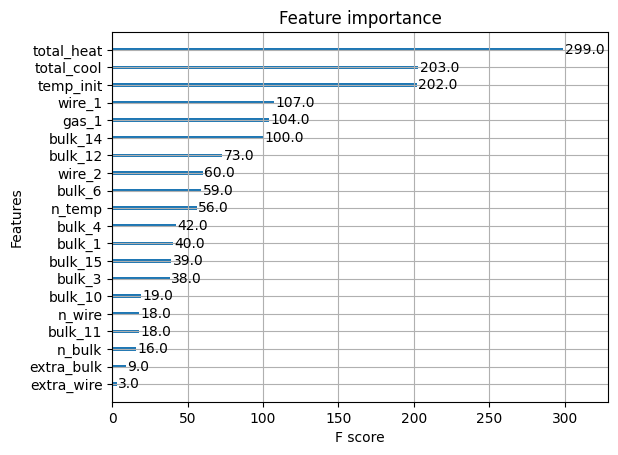

In [88]:
plot_importance(xgb_best_model.get_booster())
plt.show()

Самыми важными признаками оказались мера теплоты/энергии, затраченной на нагрев, начальная температура и время охлаждения, что довольно логично.

## Вывод

Целью проекта была разработка модели для предсказания температуры стали в зависимости от различных параметров процесса обработки. В нашем распоряжении были данные о температуре и итерациях обработки разных партий стали.

Из исходных файлов мы сформировали признаки и целевой признак. Для 2329 партий мы нашли:
- `total_heat` - сумма произведений полной мощности на время нагрева;
- `total_cool` - суммарное время без нагрева;
- `bulk_i` - объем i-го сыпучего материала, i = 3, 4, 6, 10, 11, 12, 14, 15;
- `n_bulk` - число различных сыпучих материалов;
- `extra_bulk` - суммарный объем других сыпучих материалов;
- `wire_1` - объем 1-го проволочного материала;
- `wire_2` - объем 2-го проволочного материала;
- `n_wire` - число различных проволочных материалов;
- `extra_wire` - суммарный объем оставшихся проволочных метериалов;
- `gas_1` - газ;
- `n_temp` - количество замеров температуры;
- `temp_init` - начальная температура;
- `temp_final` - конечная температура, **целевой признак**.

Были рассмотрены пять моделей: линейная регрессия, случайный лес, LGBMRegressor, XGBRegressor и CatBoostRegressor. Среди этих моделей лучшей по качеству оказалась модель **XGBRegressor** с параметрами: **`learning_rate` = 0.1, `max_depth` = 4, `n_estimators` = 140**. На тестовой выборке лучшая модель показала MAE = 5.95, что лучше требуемой MAE = 6.8.

Также мы выяснили, что на конечную температуру в большей мере влияют `total_heat` - мера теплоты/энергии, затраченной на нагрев, начальная температура `temp_init` и время без нагрева `total_cool`.